In [1]:
from nn.wandb_classification_callback import WandbClassificationCallback
import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"  # tensorflow を読み込む前のタイミングですると効果あり
import tensorflow as tf

tf.random.set_seed(100)
from data_analysis.utils import Utils
import sys
import datetime
import wandb
from wandb.keras import WandbCallback
from pre_process.pre_process import PreProcess
from nn.model_base import EDLModelBase, edl_classifier_1d
from nn.losses import EDLLoss
from pre_process.json_base import JsonBase
from data_analysis.py_color import PyColor
from collections import Counter
from nn.utils import load_model, separate_unc_data
from mywandb.utils import make_ss_dict4wandb
# 環境設定
CALC_DEVICE = "gpu"
# CALC_DEVICE = "cpu"
DEVICE_ID = "0" if CALC_DEVICE == "gpu" else "-1"
os.environ["CUDA_VISIBLE_DEVICES"] = DEVICE_ID
if os.environ["CUDA_VISIBLE_DEVICES"] != "-1":
    tf.keras.backend.set_floatx("float32")
    physical_devices = tf.config.list_physical_devices("GPU")
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
    # tf.config.run_functions_eagerly(True)
else:
    print("*** cpuで計算します ***")
    # なんか下のやつ使えなくなっている、、
    # tf.config.run_functions_eagerly(True)

In [2]:
TEST_RUN = False
HAS_ATTENTION = True
PSE_DATA = False
HAS_INCEPTION = True
IS_PREVIOUS = True
IS_NORMAL = True
IS_ENN = True  # FIXME: always true so remove here
IS_MUL_LAYER = False
CATCH_NREM2 = True
EPOCHS = 200
BATCH_SIZE = 16
N_CLASS = 5
KERNEL_SIZE = 512
STRIDE = 480
SAMPLE_SIZE = 2000
UNC_THRETHOLD = 0.5
DATA_TYPE = "spectrum"
FIT_POS = "middle"
EXPERIMENT_TYPES = (
    "no_cleansing",
    "positive_cleansing",
    "negative_cleansing",
)
EXPERIENT_TYPE = "no_cleansing"
NORMAL_TAG = "normal" if IS_NORMAL else "sas"
ATTENTION_TAG = "attention" if HAS_ATTENTION else "no-attention"
PSE_DATA_TAG = "psedata" if PSE_DATA else "sleepdata"
INCEPTION_TAG = "inception" if HAS_INCEPTION else "no-inception"
WANDB_PROJECT = "test" if TEST_RUN else "enn4fixed_stride_fixed_sample"
ENN_TAG = "enn" if IS_ENN else "dnn"
INCEPTION_TAG += "v2" if IS_MUL_LAYER else ""
CATCH_NREM2_TAG = "catch_nrem2" if CATCH_NREM2 else "catch_nrem34"

In [5]:
# モデルの読み込み
loaded_name = "H_Li"
date_id = {"nothing":"20211101-103506", "negative":"20211101-103506", "positive":"20211101-103506"}
n_class = 5
model = load_model(loaded_name=loaded_name, model_id=date_id, n_class=n_class, verbose=0)
# model.summary()

In [6]:
# Recordオブジェクトの読み込み
pre_process = PreProcess(
    data_type=DATA_TYPE,
    fit_pos=FIT_POS,
    verbose=0,
    kernel_size=KERNEL_SIZE,
    is_previous=IS_PREVIOUS,
    stride=STRIDE,
    is_normal=IS_NORMAL,
    has_nrem2_bias=False
)
datasets = pre_process.load_sleep_data.load_data(
    load_all=True, pse_data=PSE_DATA
)
utils = Utils(catch_nrem2=CATCH_NREM2)

*** すべての被験者を読み込みます（load_dataの引数:nameは無視します） ***
 H_Li を読み込みます 
 H_Murakami を読み込みます 
 H_Yamamoto を読み込みます 
 H_Kumazawa を読み込みます 
 H_Hayashi を読み込みます 
 H_Kumazawa_F を読み込みます 
 H_Takadama を読み込みます 
 H_Hiromoto を読み込みます 
 H_Kashiwazaki を読み込みます 


In [11]:
# 訓練データとテストデータの分類
(train, test) = pre_process.split_train_test_from_records(
    datasets, test_id=0, pse_data=PSE_DATA 
)
(x_train, y_train), (x_test, y_test) = pre_process.make_dataset(
    train=train,
    test=test,
    is_storchastic=False,
    pse_data=PSE_DATA,
    to_one_hot_vector=False,
    each_data_size=SAMPLE_SIZE,
    is_shuffle=False,
)

- 訓練データのサイズを揃えます
訓練データの各睡眠段階（補正前） Counter({2: 3147, 4: 1086, 5: 495, 3: 385, 1: 28, None: 8})
訓練データの各睡眠段階（補正後） {1: 2000, 2: 2000, 3: 2000, 4: 2000, 5: 2000}
- noneの処理を行います
- max正規化を行います
- チャンネル方向に軸を追加します
*** 全ての前処理後（one-hotを除く）の訓練データセット（確認用） *** 
 Counter({0: 2000, 1: 2000, 2: 2000, 3: 2000, 4: 2000})


In [21]:
# データを各睡眠段階ごとに分類する
sep_size = 2000
x_train_nr34 = x_train[:sep_size]
# y_test_nr34 = y_test[:]
x_train_nr2 = x_train[sep_size:sep_size * 2]
# y_test_nr2 = y_test[40000:120000]
x_train_nr1 = x_train[sep_size * 2:sep_size * 3]
# y_test_nr1 = y_test[120000:160000]
x_train_rem = x_train[sep_size * 3: sep_size * 4]
# y_test_rem = y_test[160000:200000]
x_train_wake = x_train[sep_size * 4:]
# y_test_wake = y_test[200000:]

In [34]:
y_train[2000*3:2000*4].max()

3

In [16]:
model.summary()

Model: "edl_model_base"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 1)]     0                                            
__________________________________________________________________________________________________
shrink_tensor_layer (Conv1D)    (None, 127, 3)       15          input_1[0][0]                    
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 3)       0           shrink_tensor_layer[0][0]        
__________________________________________________________________________________________________
first_layer_conv (Conv1D)       (None, 63, 32)       288         activation[0][0]                 
_____________________________________________________________________________________

In [13]:
# データセットの選択
x_test.shape

(848, 256, 1)

In [12]:
# モデルのアテンションを抽出
model.layers[-7].output
new_model = tf.keras.Model(inputs=model.input, outputs=model.layers[-7].output)

In [14]:
att_nr1 = new_model.predict(x_test)

In [15]:
# 可視化
import matplotlib.pyplot as plt
%matplotlib inline
# fig = plt.figure()
# ax = fig.add_subplot(111)
fig, axes = plt.subplots(1, 30, figsize=(20, 20))
axes = axes.flatten()
for img, ax in zip(att_nr1, axes):
    ax.imshow(img)
    ax.axis("off")
plt.tight_layout()
# im = ax.imshow(att_nr1[4])
# cbar = fig.colorbar(im)
plt.savefig("attention.png")

In [25]:
# 主成分分析をやってみる
import numpy as np
from sklearn.decomposition import PCA
x_train_nr1 = np.reshape(x_train_nr1, (-1, 256))
# x_train_nr2 = np.reshape(x_train_nr2, (-1, 256))
# 第2主成分までをプロット
# pca = PCA(n_components=2)
x_train4pca = np.reshape(x_train, (-1, 256))
pca = PCA()
pca.fit(x_train4pca)
feature_train = pca.transform(x_train4pca)
# feature_nr2 = pca.fit(x_train_nr2)
# feature_nr2 = pca.transform(x_train_nr2)

In [64]:
pca_1_dot

array([ 0.63654822,  0.70715487,  0.98795453,  0.81806447,  0.77111939,
        1.42761946,  1.08831402,  0.52602787,  0.80419884,  0.62076923,
        0.69170254,  0.85716097,  0.594373  ,  0.69170254,  0.27373025,
        0.83829534,  0.317043  ,  1.13531283,  1.42761946,  0.27373025,
        0.56203093,  1.42761946,  0.52602787,  0.56203093,  0.63654822,
        0.56061717,  0.4135006 ,  0.51801239,  0.27373025,  0.41141802,
        0.67094237,  0.63654822,  0.67494404,  0.81806447,  1.11128425,
        0.67094237,  0.677498  ,  0.77111939,  0.78426307,  0.70604814,
        0.51801239,  0.86615867,  0.62001665,  0.98795453,  0.81840819,
        0.78426307,  0.26189075, -0.01075031,  0.43279752,  1.33621184,
        1.28921434,  0.26189075,  0.40343399,  0.24328767,  1.28921434,
        0.75733209,  0.8888804 ,  1.33621184,  0.40343399,  1.00149871,
        0.79409673,  0.32057364,  0.4492216 ,  0.58726409,  0.35927564,
        0.51604642,  0.26189075,  0.14679959,  0.95584083,  0.83

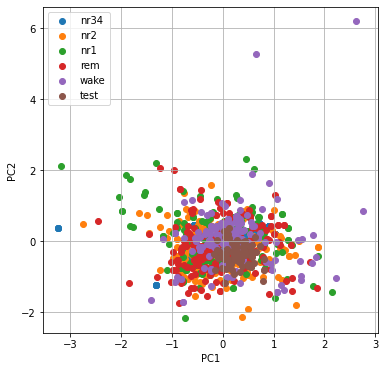

In [75]:
axis_1, axis_2 = 5, 6
x_test4pca = np.reshape(x_test, (-1, 256))
# 第一、第二主成分ベクトル
pca_1, pca_2 = pca.components_[:, axis_1], pca.components_[:, axis_2]
# 各主成分ベクトルが正規化されていることの確認
# np.linalg.norm(pca_2, ord=2)
# x_test4pca: (848, 256), pca_1: (256,)
# x_testの第一主成分方向の射影
pca_1_dot = np.dot(x_test4pca, pca_1)
# x_testの第二主成分方向の射影
pca_2_dot = np.dot(x_test4pca, pca_2)
#第2主成分まででプロット
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 6))
plt.scatter(feature_train[sep_size*0:sep_size*1:10, axis_1], feature_train[sep_size*0:sep_size*1:10, axis_2], label="nr34")
plt.scatter(feature_train[sep_size*1:sep_size*2:10, axis_1], feature_train[sep_size*1:sep_size*2:10, axis_2], label="nr2")
plt.scatter(feature_train[sep_size*2:sep_size*3:10, axis_1], feature_train[sep_size*2:sep_size*3:10, axis_2], label="nr1")
plt.scatter(feature_train[sep_size*3:sep_size*4:10, axis_1], feature_train[sep_size*3:sep_size*4:10, axis_2], label="rem")
plt.scatter(feature_train[sep_size*4:sep_size*5:10, axis_1], feature_train[sep_size*4:sep_size*5:10, axis_2], label="wake")
plt.scatter(pca_1_dot[::10], pca_2_dot[::10], label="test")
# projection of test data
# plt.scatter(feature_nr2[::100, 0], feature_nr2[::100, 1], label="nr2")
plt.grid()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig("tmp.png")

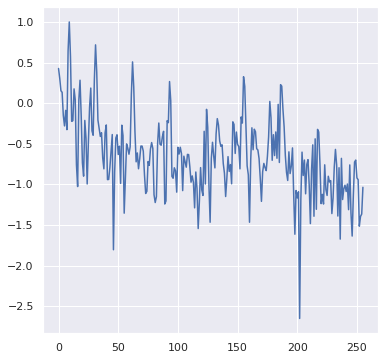

In [249]:
# スペクトルをプロット
plt.figure(figsize=(6, 6))
plt.plot(x_train[5])
plt.savefig("tmp.png")

In [92]:
# 主成分
print(pca.components_.shape)
# 平均
print(pca.mean_.shape)
# 分散
print(pca.get_covariance().shape)

(2, 256)
(256,)
(256, 256)


In [98]:
pca.get_covariance()[1]

-0.00817312815159649

In [105]:
f1.shape

(470, 408)

In [106]:
f2.shape

(470, 408)

In [155]:
# ENNを用いた予測
evidence = model.predict(x_test)
alpha = evidence + 1
y_pred = alpha / tf.reduce_sum(alpha, axis=1, keepdims=True)
y_pred = np.argmax(y_pred, axis=1)
unc = 5 / tf.reduce_sum(alpha, axis=1, keepdims=True).numpy()

In [156]:
unc.shape

(913, 1)

In [158]:
# データフレームへの書き出し
import pandas as pd
spectrum = [f"dim_{i}" for i in range(256)]
# class = ["class"]
# 主成分（固有ベクトル）
# pca.components_.shape
# くっつけるためにreshape
y_test4table = y_test.reshape(-1, 1)
y_pred4table = y_pred.reshape(-1, 1)
table = np.hstack([y_test4table, y_pred4table, unc, feature_test])
header = ["y_true"] + ["y_pred"] + ["unc"] + spectrum
table_with_header = np.vstack([header, table])
# データフレームへの出力（CSVではないよ）
df = pd.DataFrame(table_with_header)
df.to_csv("tmp.csv")

No handles with labels found to put in legend.


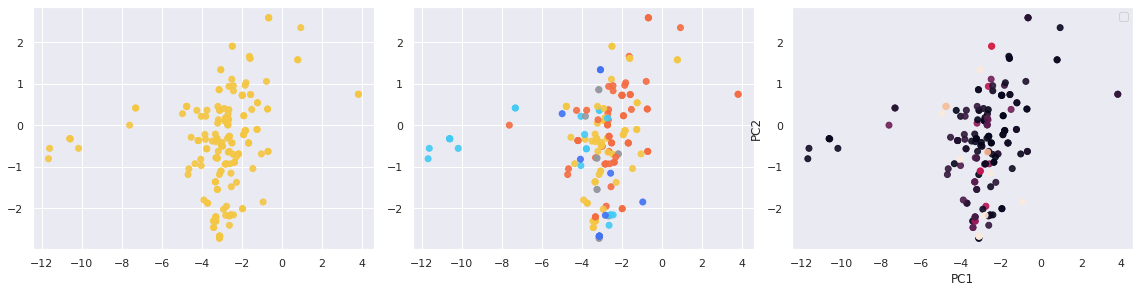

In [290]:
#第2主成分まででプロット
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
x_axis = 0
y_axis = 1
stride = 1
# nrem1
# stop = 41
# nrem2
start = 41
# stop = 462
# nrem34
# start = 464
stop = 626
# wake
start = 628
stop = 738
# rem
start = 739
stop = 914
ss_color = ["#4372f4", "#f46d43", "#9799a0", "#f4c643", "#43caf4"]
y_test4ss = [ss_color[int(id)] for id in y_test]
y_pred4ss = [ss_color[int(id)] for id in y_pred]
fig = plt.figure(figsize=(16, 4))
ax = fig.add_subplot(1, 3, 1)
ax.scatter(feature_test[start:stop:stride, x_axis], feature_test[start:stop:stride, y_axis], alpha=0.9, c=y_test4ss[start:stop:stride])
ax = fig.add_subplot(1, 3, 2)
ax.scatter(feature_test[start:stop:stride, x_axis], feature_test[start:stop:stride, y_axis], alpha=0.9, c=y_pred4ss[start:stop:stride])
ax = fig.add_subplot(1, 3, 3)
ax.scatter(feature_test[start:stop:stride, x_axis], feature_test[start:stop:stride, y_axis], alpha=0.9, c=unc[start:stop:stride])
plt.tight_layout()
# plt.colorbar()
# cbar = fig.colorbar(y_test)
# plt.scatter(feature_nr2[::100, 0], feature_nr2[::100, 1], label="nr2")
plt.grid()
plt.legend()
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.savefig("3pict.png")
# plt.show()

In [279]:
tmp = np.dot(x_train[0].T, x_train[0])
tmp

array([[110.49582606]])

In [280]:
tf.reduce_sum(np.abs(x_train[0]), axis=0)

<tf.Tensor: shape=(1,), dtype=float64, numpy=array([151.22139406])>

In [2]:
# スペクトログラムの作成
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng()

In [33]:
fs = 10e3
N = 1e5
amp = 2 * np.sqrt(2)
noise_power = 0.01 * fs / 2
time = np.arange(N) / float(fs)
mod = 500*np.cos(2*np.pi*0.25*time)
carrier = amp * np.sin(2*np.pi*3e3*time + mod)
noise = rng.normal(scale=np.sqrt(noise_power), size=time.shape)
noise *= np.exp(-time/5)
x = carrier + noise

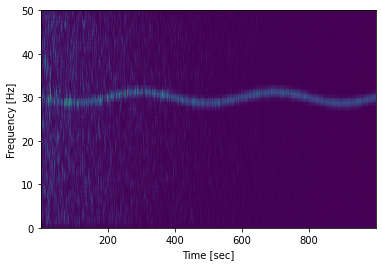

In [55]:
# nperseg: kernelsize, noverlap: 被るサイズ
f, t, Sxx = signal.spectrogram(x=x, 
                               fs=100, 
                               window=('hann'), 
                               nperseg=100, 
                               noverlap=0, 
                               scaling="density",
                               mode="psd")
plt.pcolormesh(t, f, Sxx, shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

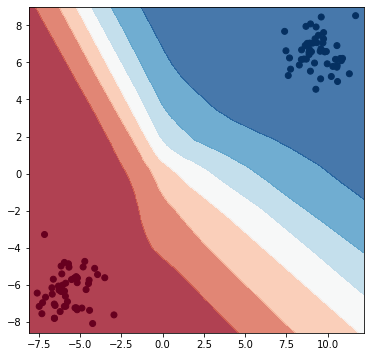

In [109]:
from sklearn.datasets import make_blobs
from sklearn.neural_network import MLPClassifier

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

if __name__ == "__main__":

    # サンプルデータを生成する
    x, y = make_blobs(n_samples=100, n_features=2, centers=2)

    # 分類モデル（※今回はニューラルネットワーク）を作成する
    estimator = MLPClassifier()
    estimator.fit(x, y)

    # サンプルデータの値域を求める
    f1_min = x[:, 0].min() - 0.5
    f1_max = x[:, 0].max() + 0.5
    f2_min = x[:, 1].min() - 0.5
    f2_max = x[:, 1].max() + 0.5

    step = 0.02
    f1_range = np.arange(f1_min, f1_max, step)
    f2_range = np.arange(f2_min, f2_max, step)
    f1, f2 = np.meshgrid(f1_range, f2_range)

    # 決定境界を描画する
    Z = estimator.predict_proba(np.c_[f1.ravel(), f2.ravel()])[:, 1]
    Z = Z.reshape(f1.shape)
    plt.figure(figsize=(6, 6))
    plt.contourf(f1, f2, Z, cmap=plt.cm.RdBu, alpha=0.8)
    plt.scatter(x[:,0], x[:,1], c=y, cmap=plt.cm.RdBu)
    plt.show()